In [25]:
# 1️⃣ Setup
import subprocess
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Only change to parent if we're currently inside "analysis"
if os.path.basename(os.getcwd()) == "analysis":
    os.chdir("..")

print("Current working directory:", os.getcwd())
# Create necessary directories
os.makedirs("analysis/results_heat", exist_ok=True)
os.makedirs("analysis/models_heat", exist_ok=True)
os.makedirs("analysis/figures_heat", exist_ok=True)


# Parameters
K_VALUES = [3, 5, 7, 9, 11, 13]
ALPHA_VALUES = [0.001, 0.01, 0.05, 0.1, 0.2, 1]
# Target IDs
target_input = input("Enter target IDs separated by commas (e.g., New1,New2): ")
TARGET_IDS = [tid.strip() for tid in target_input.split(",")]
# User input for file paths
META_FILE = input("Enter the path to the metagenomic sample file (meta): ")
DB_FILE = input("Enter the path to the reference database file (db): ")
if not os.path.exists(META_FILE):
    raise FileNotFoundError(f"Meta file not found: {META_FILE}")
if not os.path.exists(DB_FILE):
    raise FileNotFoundError(f"DB file not found: {DB_FILE}")
MODELS_DIR = "analysis/models_heat"
RESULTS = {}


Current working directory: /Users/andreoliveira/Documents/GitHub/Projeto-TAI-2


In [26]:
# 2️⃣ Function to train a model for a given k
def run_models_generator(k):
    model_path = f"{MODELS_DIR}/k{k}.bin"
    print(f"🔧 Training model for k={k}...")
    try:
        subprocess.run([
            "./src/bin/models_generator.out",
            "-meta", META_FILE,
            "-k", str(k)
        ], check=True)
        os.rename(f"models/k{k}.bin", model_path)
    except subprocess.CalledProcessError as e:
        print(f"❌ Error training model for k={k}: {e}")
        return None
    return model_path

# 3️⃣ Function to compute NRC values using a model
def run_main(model_path, alpha, k):
    output_file = f"analysis/results_heat/result_k{k}_a{alpha}.txt"
    with open(output_file, "w") as out:
        subprocess.run([
            "./src/bin/main.out",
            "-db", DB_FILE,
            "-m", model_path,
            "-a", str(alpha),
            "-t", "100"
        ], stdout=out, check=True)
    return output_file


In [27]:
# 4️⃣ Extract NRC values for the target sequences from a result file
def extract_nrc_for_targets(file_path, targets):
    nrc_map = {name: None for name in targets}
    with open(file_path, "r") as f:
        for line in f:
            for name in targets:
                if name in line:
                    match = re.search(r'NRC:\s*([\d.]+)', line)
                    if match:
                        nrc_map[name] = float(match.group(1))
    return nrc_map


In [28]:
# 5️⃣ Run all (k, alpha) combinations and gather results
for k in K_VALUES:
    model_path = run_models_generator(k)
    if model_path is None:
        continue
    for alpha in ALPHA_VALUES:
        out_file = run_main(model_path, alpha, k)
        nrcs = extract_nrc_for_targets(out_file, TARGET_IDS)
        for target in TARGET_IDS:
            RESULTS.setdefault(target, {})[(k, alpha)] = nrcs[target]


🔧 Training model for k=3...
Modelo gerado e guardado em models/k3.bin
🔧 Training model for k=5...
Modelo gerado e guardado em models/k5.bin
🔧 Training model for k=7...
Modelo gerado e guardado em models/k7.bin
🔧 Training model for k=9...
Modelo gerado e guardado em models/k9.bin
🔧 Training model for k=11...
Modelo gerado e guardado em models/k11.bin
🔧 Training model for k=13...
Modelo gerado e guardado em models/k13.bin


📊 NRC Heatmap for New1


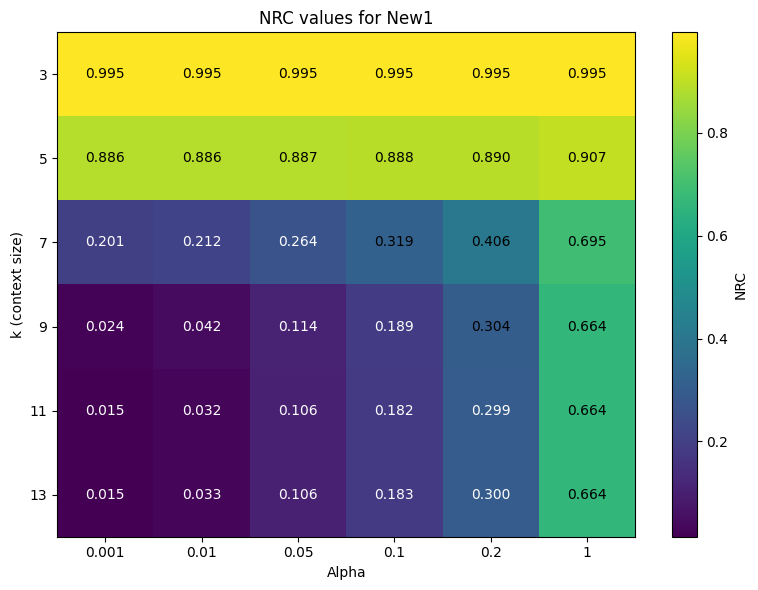

📊 NRC Heatmap for New2


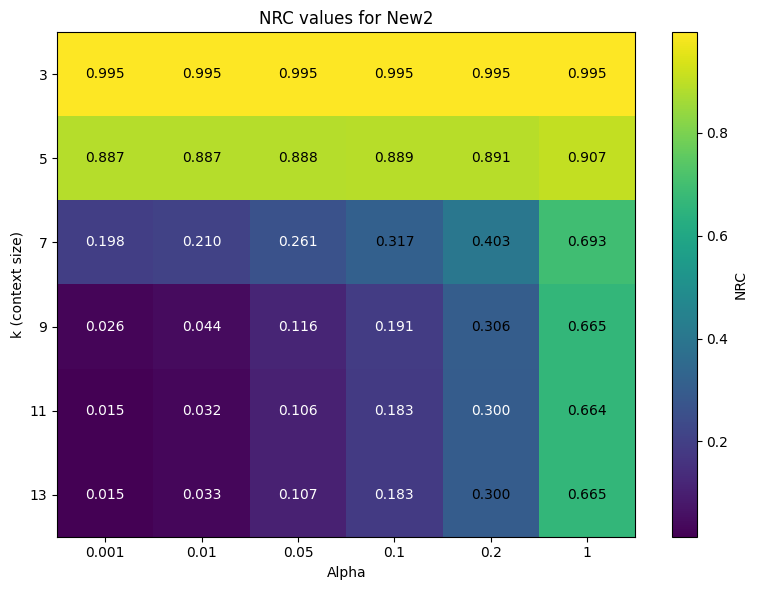

In [29]:
# 6️⃣ Plot heatmaps for each target
for target in TARGET_IDS:
    print(f"📊 NRC Heatmap for {target}")
    z = []
    for k in K_VALUES:
        row = []
        for a in ALPHA_VALUES:
            val = RESULTS[target][(k, a)]
            row.append(val if val is not None else np.nan)
        z.append(row)

    z = np.array(z)
    plt.figure(figsize=(8, 6))
    plt.imshow(z, cmap='viridis', interpolation='nearest', aspect='auto')
    plt.colorbar(label='NRC')
    plt.xticks(ticks=range(len(ALPHA_VALUES)), labels=ALPHA_VALUES)
    plt.yticks(ticks=range(len(K_VALUES)), labels=K_VALUES)
    plt.xlabel("Alpha")
    plt.ylabel("k (context size)")
    plt.title(f"NRC values for {target}")

    for i in range(len(K_VALUES)):
        for j in range(len(ALPHA_VALUES)):
            val = z[i, j]
            if not np.isnan(val):
                plt.text(j, i, f"{val:.3f}", ha='center', va='center', color='white' if val < 0.3 else 'black')

    plt.tight_layout()
    plt.savefig(f"analysis/figures_heat/nrc_heatmap_{target}.png")
    plt.show()
